In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import re
from datetime import datetime, timedelta
import math
from scipy import stats

In [4]:
fly = pd.read_csv('flight.csv')
fly.head(3)

,flight_id,flight_no,aircraft_code,model,departure_airport,arrival_airport,city,month_flight,seats_total,ticket_sale_total,amount_total,time_fly
0,136119,PG0252,733,Boeing 737-300,AAQ,SVO,Moscow,1.0,130,113.0,1653000.0,100.0
1,136120,PG0252,733,Boeing 737-300,AAQ,SVO,Moscow,2.0,130,109.0,1605400.0,100.0
2,136122,PG0252,733,Boeing 737-300,AAQ,SVO,Moscow,1.0,130,97.0,1431000.0,100.0


In [6]:
fly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   flight_id          193 non-null    int64  
 1   flight_no          193 non-null    object 
 2   aircraft_code      193 non-null    object 
 3   model              193 non-null    object 
 4   departure_airport  193 non-null    object 
 5   arrival_airport    193 non-null    object 
 6   city               193 non-null    object 
 7   month_flight       193 non-null    float64
 8   seats_total        193 non-null    int64  
 9   ticket_sale_total  180 non-null    float64
 10  amount_total       180 non-null    float64
 11  time_fly           193 non-null    float64
dtypes: float64(4), int64(2), object(6)
memory usage: 18.2+ KB


цель анализа - выявить наиолее прибыльные рейсы. Для определения прибыльности необходимо выяснить издержки на перелеты, в данном случае возьмем наиболее затратную ее часть - топливо

In [7]:
#расход топлива по каждому виду самолета представим в виде словаря в кг топлива на 1 час лета (часовой расход) (данные из wikipedia.org)
oil = {'Boeing 737-300': 2400, 'Sukhoi Superjet-100': 1700}
fly['airplane_oil'] = fly['model'].map(oil)
fly.sample(5)

,flight_id,flight_no,aircraft_code,model,departure_airport,arrival_airport,city,month_flight,seats_total,ticket_sale_total,amount_total,time_fly,airplane_oil
99,136630,PG0480,SU9,Sukhoi Superjet-100,AAQ,EGO,Belgorod,2.0,97,94.0,746400.0,50.0,1700
45,136310,PG0252,733,Boeing 737-300,AAQ,SVO,Moscow,1.0,130,117.0,1654200.0,100.0,2400
122,136729,PG0480,SU9,Sukhoi Superjet-100,AAQ,EGO,Belgorod,1.0,97,88.0,695400.0,50.0,1700
21,136209,PG0252,733,Boeing 737-300,AAQ,SVO,Moscow,1.0,130,112.0,1615200.0,100.0,2400
35,136268,PG0252,733,Boeing 737-300,AAQ,SVO,Moscow,2.0,130,115.0,1676200.0,100.0,2400


In [8]:
#цена топлива, которая действовала на момент выборки - декабрь 2016 и январь-февраль 2017 с НДС 18% (по данным https://favt.gov.ru)
price_oil = {12.0: 45.863, 1.0: 48.893, 2.0: 46.673}
fly['price_flight'] = fly['month_flight'].map(price_oil)
fly.sample(5)

,flight_id,flight_no,aircraft_code,model,departure_airport,arrival_airport,city,month_flight,seats_total,ticket_sale_total,amount_total,time_fly,airplane_oil,price_flight
38,136273,PG0252,733,Boeing 737-300,AAQ,SVO,Moscow,12.0,130,129.0,1873800.0,100.0,2400,45.863
125,136742,PG0480,SU9,Sukhoi Superjet-100,AAQ,EGO,Belgorod,12.0,97,97.0,765300.0,50.0,1700,45.863
120,136720,PG0480,SU9,Sukhoi Superjet-100,AAQ,EGO,Belgorod,1.0,97,95.0,752700.0,50.0,1700,48.893
32,136262,PG0252,733,Boeing 737-300,AAQ,SVO,Moscow,12.0,130,128.0,1861600.0,100.0,2400,45.863
51,136327,PG0252,733,Boeing 737-300,AAQ,SVO,Moscow,12.0,130,108.0,1543200.0,100.0,2400,45.863


In [9]:
#общие затраты на топливо
fly['cost_flight'] = fly['time_fly']/60 * fly['airplane_oil'] * fly['price_flight']
fly.sample(5)

,flight_id,flight_no,aircraft_code,model,departure_airport,arrival_airport,city,month_flight,seats_total,ticket_sale_total,amount_total,time_fly,airplane_oil,price_flight,cost_flight
14,136178,PG0252,733,Boeing 737-300,AAQ,SVO,Moscow,1.0,130,99.0,1434600.0,100.0,2400,48.893,195572.000000
175,136943,PG0480,SU9,Sukhoi Superjet-100,AAQ,EGO,Belgorod,12.0,97,94.0,733800.0,50.0,1700,45.863,64972.583333
114,136688,PG0480,SU9,Sukhoi Superjet-100,AAQ,EGO,Belgorod,12.0,97,89.0,689700.0,50.0,1700,45.863,64972.583333
66,136397,PG0252,733,Boeing 737-300,AAQ,SVO,Moscow,12.0,130,104.0,1444400.0,100.0,2400,45.863,183452.000000
83,136471,PG0252,733,Boeing 737-300,AAQ,SVO,Moscow,1.0,130,120.0,1762800.0,100.0,2400,48.893,195572.000000


In [10]:
#сумма прибыли
fly['income_flight'] = fly['amount_total'] - fly['cost_flight'] 
fly.sample(5)

,flight_id,flight_no,aircraft_code,model,departure_airport,arrival_airport,city,month_flight,seats_total,ticket_sale_total,amount_total,time_fly,airplane_oil,price_flight,cost_flight,income_flight
140,136800,PG0480,SU9,Sukhoi Superjet-100,AAQ,EGO,Belgorod,12.0,97,82.0,645000.0,50.0,1700,45.863,64972.583333,580027.416667
156,136865,PG0480,SU9,Sukhoi Superjet-100,AAQ,EGO,Belgorod,12.0,97,88.0,695400.0,50.0,1700,45.863,64972.583333,630427.416667
109,136666,PG0480,SU9,Sukhoi Superjet-100,AAQ,EGO,Belgorod,2.0,97,87.0,664500.0,50.0,1700,46.673,66120.083333,598379.916667
146,136819,PG0480,SU9,Sukhoi Superjet-100,AAQ,EGO,Belgorod,1.0,97,96.0,759000.0,50.0,1700,48.893,69265.083333,689734.916667
165,136888,PG0480,SU9,Sukhoi Superjet-100,AAQ,EGO,Belgorod,2.0,97,79.0,626100.0,50.0,1700,46.673,66120.083333,559979.916667


In [11]:
fly.isna().sum()

flight_id             0
flight_no             0
aircraft_code         0
model                 0
departure_airport     0
arrival_airport       0
city                  0
month_flight          0
seats_total           0
ticket_sale_total    13
amount_total         13
time_fly              0
airplane_oil          0
price_flight          0
cost_flight           0
income_flight        13
dtype: int64

In [12]:
fly = fly.dropna(axis=0) #удаляем пропуски, т.к они не содержат данные, которые нам нужны

In [13]:
fly.isna().sum()

flight_id            0
flight_no            0
aircraft_code        0
model                0
departure_airport    0
arrival_airport      0
city                 0
month_flight         0
seats_total          0
ticket_sale_total    0
amount_total         0
time_fly             0
airplane_oil         0
price_flight         0
cost_flight          0
income_flight        0
dtype: int64

далее проверим, насколько эффективными были затраты - все ли билеты были проданы и была ли недоплученныая прибыль из-за непроданных билетов

In [14]:
fly.sample(5)

,flight_id,flight_no,aircraft_code,model,departure_airport,arrival_airport,city,month_flight,seats_total,ticket_sale_total,amount_total,time_fly,airplane_oil,price_flight,cost_flight,income_flight
170,136922,PG0480,SU9,Sukhoi Superjet-100,AAQ,EGO,Belgorod,2.0,97,76.0,607800.0,50.0,1700,46.673,66120.083333,5.416799e+05
172,136929,PG0480,SU9,Sukhoi Superjet-100,AAQ,EGO,Belgorod,12.0,97,82.0,631800.0,50.0,1700,45.863,64972.583333,5.668274e+05
52,136338,PG0252,733,Boeing 737-300,AAQ,SVO,Moscow,12.0,130,128.0,1861600.0,100.0,2400,45.863,183452.000000,1.678148e+06
9,136146,PG0252,733,Boeing 737-300,AAQ,SVO,Moscow,2.0,130,109.0,1604200.0,100.0,2400,46.673,186692.000000,1.417508e+06
27,136249,PG0252,733,Boeing 737-300,AAQ,SVO,Moscow,2.0,130,123.0,1800600.0,100.0,2400,46.673,186692.000000,1.613908e+06


In [15]:
#доля проданных билетов
fly['part_sale_seats'] = round ((fly['ticket_sale_total'] / fly['seats_total'])*100, 0)
fly.sample(5)

,flight_id,flight_no,aircraft_code,model,departure_airport,arrival_airport,city,month_flight,seats_total,ticket_sale_total,amount_total,time_fly,airplane_oil,price_flight,cost_flight,income_flight,part_sale_seats
165,136888,PG0480,SU9,Sukhoi Superjet-100,AAQ,EGO,Belgorod,2.0,97,79.0,626100.0,50.0,1700,46.673,66120.083333,5.599799e+05,81.0
119,136709,PG0480,SU9,Sukhoi Superjet-100,AAQ,EGO,Belgorod,1.0,97,87.0,689700.0,50.0,1700,48.893,69265.083333,6.204349e+05,90.0
172,136929,PG0480,SU9,Sukhoi Superjet-100,AAQ,EGO,Belgorod,12.0,97,82.0,631800.0,50.0,1700,45.863,64972.583333,5.668274e+05,85.0
35,136268,PG0252,733,Boeing 737-300,AAQ,SVO,Moscow,2.0,130,115.0,1676200.0,100.0,2400,46.673,186692.000000,1.489508e+06,88.0
21,136209,PG0252,733,Boeing 737-300,AAQ,SVO,Moscow,1.0,130,112.0,1615200.0,100.0,2400,48.893,195572.000000,1.419628e+06,86.0


count    180.000000
mean      90.288889
std        8.098202
min       66.000000
25%       84.000000
50%       91.000000
75%       99.000000
max      100.000000
Name: part_sale_seats, dtype: float64

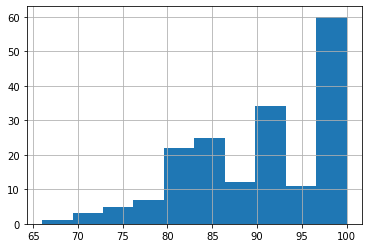

In [17]:
fly.part_sale_seats.hist()
fly.part_sale_seats.describe()

как видно из графика, наибольшую часть занимают полеты со 100% проданными местами, т.е эти перелеты наиболее эффективны, но также есть перелеты, где % заполняемости воздушных суден менее 75%

In [18]:
fly[fly['part_sale_seats'] < 75]

,flight_id,flight_no,aircraft_code,model,departure_airport,arrival_airport,city,month_flight,seats_total,ticket_sale_total,amount_total,time_fly,airplane_oil,price_flight,cost_flight,income_flight,part_sale_seats
30,136253,PG0252,733,Boeing 737-300,AAQ,SVO,Moscow,12.0,130,93.0,1407800.0,100.0,2400,45.863,183452.000000,1.224348e+06,72.0
56,136352,PG0252,733,Boeing 737-300,AAQ,SVO,Moscow,12.0,130,92.0,1372400.0,100.0,2400,45.863,183452.000000,1.188948e+06,71.0
102,136642,PG0480,SU9,Sukhoi Superjet-100,AAQ,EGO,Belgorod,1.0,97,64.0,531000.0,50.0,1700,48.893,69265.083333,4.617349e+05,66.0
144,136807,PG0480,SU9,Sukhoi Superjet-100,AAQ,EGO,Belgorod,2.0,97,68.0,531000.0,50.0,1700,46.673,66120.083333,4.648799e+05,70.0


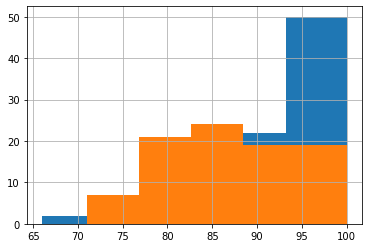

In [19]:
#распределение доли проданных билето среди направлений
for x in (fly['arrival_airport'].value_counts()).index:
    fly['part_sale_seats'][fly['arrival_airport'] == x].hist(bins=5)
plt.show()

для полного анализа % заполняемости воздушных суден недостаточно. для этого также необходимо проанализировать рентабельность перелетов

In [20]:
#рентабельность рассчитывается как отношение прибыли к доходу
fly['rentabel'] = round((fly['income_flight']/fly['amount_total']) *100, 0)
fly.sample(5)

,flight_id,flight_no,aircraft_code,model,departure_airport,arrival_airport,city,month_flight,seats_total,ticket_sale_total,amount_total,time_fly,airplane_oil,price_flight,cost_flight,income_flight,part_sale_seats,rentabel
96,136612,PG0480,SU9,Sukhoi Superjet-100,AAQ,EGO,Belgorod,2.0,97,94.0,746400.0,50.0,1700,46.673,66120.083333,6.802799e+05,97.0,91.0
179,136961,PG0480,SU9,Sukhoi Superjet-100,AAQ,EGO,Belgorod,12.0,97,96.0,759000.0,50.0,1700,45.863,64972.583333,6.940274e+05,99.0,91.0
49,136322,PG0252,733,Boeing 737-300,AAQ,SVO,Moscow,2.0,130,108.0,1567600.0,100.0,2400,46.673,186692.000000,1.380908e+06,83.0,88.0
141,136801,PG0480,SU9,Sukhoi Superjet-100,AAQ,EGO,Belgorod,12.0,97,97.0,765300.0,50.0,1700,45.863,64972.583333,7.003274e+05,100.0,92.0
170,136922,PG0480,SU9,Sukhoi Superjet-100,AAQ,EGO,Belgorod,2.0,97,76.0,607800.0,50.0,1700,46.673,66120.083333,5.416799e+05,78.0,89.0


count    180.000000
mean      89.472222
std        1.481470
min       86.000000
25%       88.000000
50%       90.000000
75%       91.000000
max       92.000000
Name: rentabel, dtype: float64


<AxesSubplot:xlabel='rentabel'>

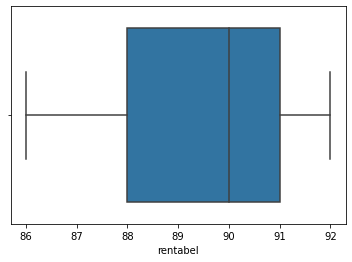

In [30]:
print(fly.rentabel.describe())
sns.boxplot(x = 'rentabel', data = fly)

как видно, все рейсы достаточно рентабельны, минимальная рентабельность рейсов составила 86%  и сильного разброса данных по этому показателю не наблюдается. Сравним рентабельность рейсов по моделям самолетов

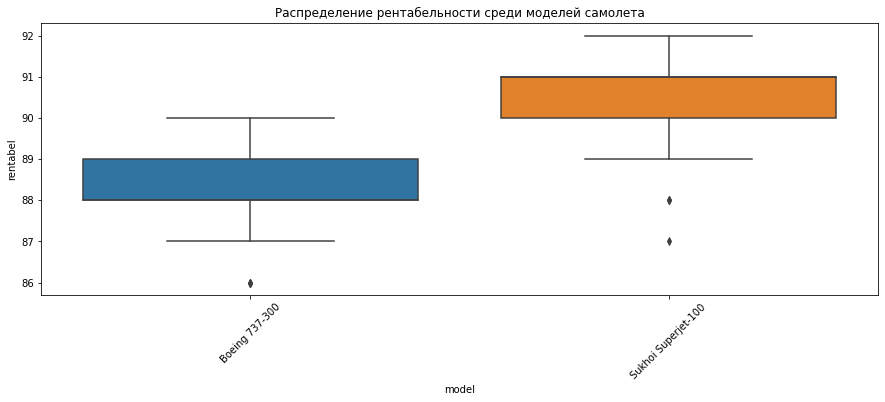

In [22]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.boxplot(x='model', y='rentabel',
            data=fly.loc[fly.loc[:, 'model'].isin(
                fly.loc[:, 'model'].value_counts().index[:])],
            ax=ax)

plt.xticks(rotation=45)
ax.set_title('Распределение рентабельности среди моделей самолета')

plt.show()

из приведенных выше графиков видно, что рентабельность рейсов, где использовался Boeing выше, чем рейсов, где летал Sukhoi Superjet

<AxesSubplot:xlabel='income_flight', ylabel='part_sale_seats'>

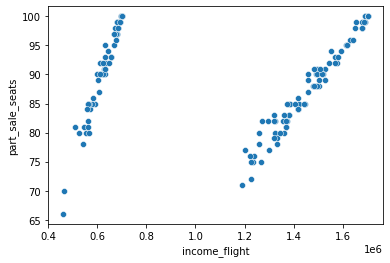

In [35]:
# визуализируем зависимость загруженности самолета и его прибыльности
sns.scatterplot(x=fly.income_flight, y=fly.part_sale_seats)

как видно, прибыльность рейса и его загрузка тесно взаимосвязаны. Здесь видно, что часть рейсов имеют прибыль менее 800000 руб. Посмотрим на эти рейсы. На этом графике также видны рейсы, загруженность которых менее 75%. Эти рейсы требуют дополнительного анализа

проанализируем перелеты с низкой рентабельностью (где рентабельность находится ниже Q1 - менее 88 %) и долю проданных билетов

<AxesSubplot:ylabel='part_sale_seats'>

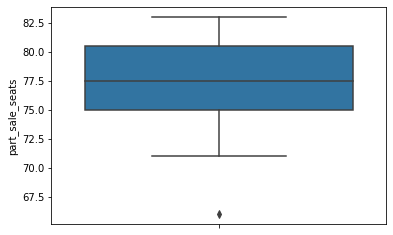

In [25]:
rentabel = fly[fly.rentabel < 88]
rentabel['part_sale_seats'].describe()
sns.boxplot(y = 'part_sale_seats',  data = rentabel)

<AxesSubplot:title={'center':'Количество полетов с разными уровнями загруженности в низкорентабельных рейсах'}>

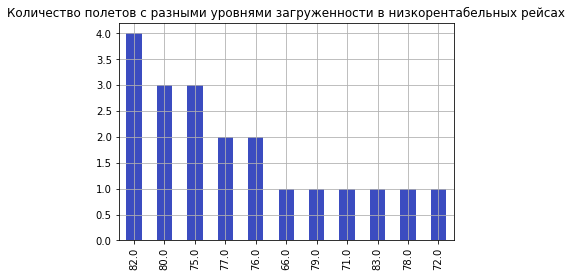

In [26]:
rentabel['part_sale_seats'].value_counts().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Количество полетов с разными уровнями загруженности в низкорентабельных рейсах')

из представленных выше расчетов и графиков можно сделать вывод, что рейсы, у которых рентабельность ниже 88%, а % проданных билетов (загрузки мест воздушного судна) менее 75% следует либо изменить пересмотреть. Например, поменять самолет на более экономичный как с точки зрения рахода топлива, так и по количеству посадочных мест

In [47]:
#к этим рейсам относятся
seats75 = rentabel[rentabel['part_sale_seats'] < 75]
seats75[['flight_id','flight_no', 'arrival_airport', 'city', 'month_flight', 'part_sale_seats', 'rentabel' ]]

,flight_id,flight_no,arrival_airport,city,month_flight,part_sale_seats,rentabel
30,136253,PG0252,SVO,Moscow,12.0,72.0,87.0
56,136352,PG0252,SVO,Moscow,12.0,71.0,87.0
102,136642,PG0480,EGO,Belgorod,1.0,66.0,87.0
